<h1 style="text-align: center;">Project title: Customer Churn Prediction for Telecom Operator Interconnect </h1>   

#### Introduction.

In this project, we aim to **predict customer churn** for the telecom operator *Interconnect* using machine learning. The company wants to forecast which users are planning to leave and will offer them promotional codes and special plan options. We start by preprocessing and integrating four datasets, preparing them for exploratory data analysis (EDA). Through feature engineering, we define the key input features and the target variable for a supervised binary classification task.  

To build the churn prediction model, we will train and evaluate several classification algorithms:  

- Logistic Regression  
- Random Forest Classifier  
- LightGBM  
- XGBoost  
- CatBoost
   
Model performance will be evaluated using key metrics, including accuracy, ROC-AUC, and F1 score. Through hyperparameter tuning, our goal is to achieve a ROC-AUC score above 0.75. The best-performing classifier will be selected to reliably predict customer churn for Interconnect.

Finally, the selected model will be used to build and deploy a web application, incorporating core principles of machine learning system design.

## 1. Packages

In [3]:
# importing packages

import pandas as pd
import numpy as np
import os, joblib, json, datetime
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## 2. Data loading and cleaning

In [6]:
# Data loading and merging 

def load_and_preprocess():
    contract = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phone = pd.read_csv('phone.csv')

    # merging datasets: 'contract' - master dataset, left join other three datasets to it:
    df_raw = contract.merge(personal, on='customerID', how='left') \
                 .merge(internet, on='customerID', how='left') \
                 .merge(phone, on='customerID', how='left')

    # Rename to lowercase snake_case
    df_raw.columns = [col.lower().replace('customerid', 'customer_id') for col in df_raw.columns]
    df_raw.rename(columns={'begindate': 'begin_date', 'enddate': 'end_date', 'paperlessbilling': 'paperless_billing', 
                       'paymentmethod': 'payment_method', 'monthlycharges': 'monthly_charges', 
                       'totalcharges': 'total_charges', 'seniorcitizen': 'senior_citizen',
                       'internetservice': 'internet_service', 'onlinesecurity': 'online_security',
                       'onlinebackup': 'online_backup', 'deviceprotection': 'device_protection',
                       'techsupport': 'tech_support', 'streamingtv': 'streaming_tv',
                       'streamingmovies': 'streaming_movies', 'multiplelines': 'multiple_lines'}, inplace=True)

    
    # Handle Total Charges
    df_raw['total_charges'] = pd.to_numeric(df_raw['total_charges'], errors='coerce').fillna(df_raw['monthly_charges'])

    # We create target called 'churn':
    df_raw['churn'] = (df_raw['end_date'] != 'No').astype(int) 
    
    # we convert 'begin_date', and 'end_date' to datetime type
    df_raw['begin_date'] = pd.to_datetime(df_raw['begin_date'])  
    df_raw['end_date'] = pd.to_datetime(df_raw['end_date'], errors='coerce')
    
    # We define 'cutoff' value
    cutoff = df_raw['end_date'].max()
    
    # we create 'tenure_days' column
    df_raw['tenure_days'] = (df_raw['end_date'].fillna(cutoff) - df_raw['begin_date']).dt.days

    # We fill NaNs
    cat_to_fill = ['internet_service', 'online_security', 'online_backup', 'device_protection', 
                   'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
    df_raw[cat_to_fill] = df_raw[cat_to_fill].fillna('No')

    return df_raw

df_full = load_and_preprocess()
#print(df_full.info())
#print(df_full.head())


/var/folders/p7/krbf_vbj2lqf31fmqjz_j8xm0000gn/T/ipykernel_27333/2244723796.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw['end_date'] = pd.to_datetime(df_raw['end_date'], errors='coerce')


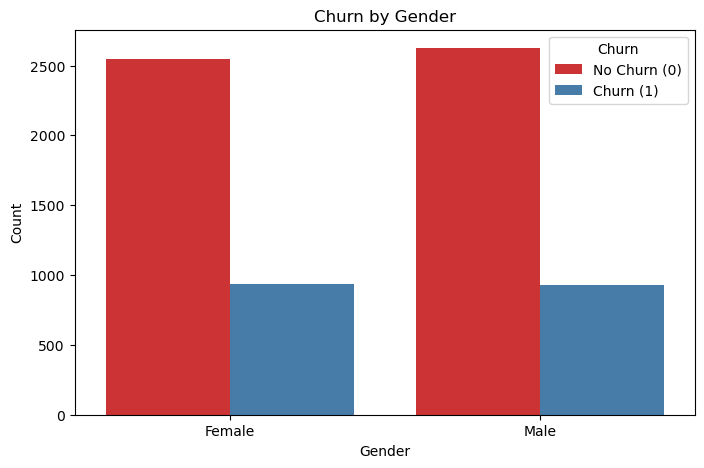

In [8]:
# EDA 

plt.figure(figsize=(8, 5))
sns.countplot(data=df_full, x='gender', hue='churn', palette='Set1')
plt.title('Churn by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right', labels=['No Churn (0)', 'Churn (1)'])
plt.show()

### Above shown picture shows: target values (0, 1) are imbalanced; No significant dependence of target values on 'gender' values.  

In [11]:
# Drop non-feature columns for ML

df = df_full.drop(columns=['customer_id', 'gender', 'begin_date', 'end_date'])


### 1.1. Data Preprocessing 

In [14]:
# 3-way split (Train 60%, Valid 20%, Test 20%)

X = df.drop('churn', axis=1)
y = df['churn']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=12345, stratify=y_temp)

# 3. PREPROCESSING PIPELINE
cat_features = ['type', 'paperless_billing', 'payment_method', 'partner', 'dependents', 
                'internet_service', 'online_security', 'online_backup', 'device_protection', 
                'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
num_features = ['monthly_charges', 'total_charges', 'tenure_days']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
    ('num', StandardScaler(), num_features),
    ('pass', FunctionTransformer(), ['senior_citizen'])
])


## Model comparison

In [17]:
# Model evaluation (three metrics):

def evaluate_pipeline(name, model_obj, params):
    pipe = Pipeline([('pre', preprocessor), ('model', model_obj)])
    grid = GridSearchCV(pipe, params, scoring='roc_auc', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_pipe = grid.best_estimator_
    y_pred = best_pipe.predict(X_valid)               # to calculate accuracy and F1_score
    y_probs = best_pipe.predict_proba(X_valid)[:, 1]  # probability to calculate ROC-AUC
    
    metrics = {
        'ROC-AUC': roc_auc_score(y_valid, y_probs),
        'Accuracy': accuracy_score(y_valid, y_pred),
        'F1': f1_score(y_valid, y_pred)
    }
    
    print(f"\n--- {name} Results ---")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
        
    return best_pipe, metrics


## Models Execution

In [20]:
# Model execution (five models): 

results = {}

# 1. Logistic Regression
results['LR'], _ = evaluate_pipeline("Logistic Regression", 
    LogisticRegression(class_weight='balanced', random_state=12345),
    {'model__C': [0.1, 1, 10]})

# 2. Random Forest
results['RF'], _ = evaluate_pipeline("Random Forest", 
    RandomForestClassifier(class_weight='balanced', random_state=12345),
    {'model__max_depth': [10, 20], 'model__n_estimators': [100]})

# 3. LightGBM
results['LGBM'], _ = evaluate_pipeline("LightGBM", 
    LGBMClassifier(class_weight='balanced', verbose=-1),
    {'model__num_leaves': [31, 50], 'model__learning_rate': [0.1, 0.05]})

# 4. XGBoost
results['XGB'], _ = evaluate_pipeline("XGBoost", 
    XGBClassifier(eval_metric='logloss', random_state=42),
    {'model__max_depth': [3, 5], 'model__n_estimators': [50, 100]})

# 5. CatBoost (Special handling for cat_features)
# Note: Since our preprocessor handles encoding, we treat it like the others
results['CatBoost'], _ = evaluate_pipeline("CatBoost", 
    CatBoostClassifier(verbose=0, random_state=42),
    {'model__depth': [4, 6], 'model__iterations': [100]})


--- Logistic Regression Results ---
ROC-AUC: 0.8508
Accuracy: 0.7580
F1: 0.6368

--- Random Forest Results ---
ROC-AUC: 0.8751
Accuracy: 0.8133
F1: 0.6741

--- LightGBM Results ---
ROC-AUC: 0.9078
Accuracy: 0.8297
F1: 0.7066

--- XGBoost Results ---
ROC-AUC: 0.9118
Accuracy: 0.8623
F1: 0.7069

--- CatBoost Results ---
ROC-AUC: 0.9106
Accuracy: 0.8602
F1: 0.7020


#### The best ROC-AUC has been obtained with XGBoost model: 0.9118

--- FINAL TEST SET METRICS (XGBoost) ---
Test Accuracy: 0.8581
Test F1 Score: 0.7059
Test ROC-AUC:  0.8953
----------------------------------------


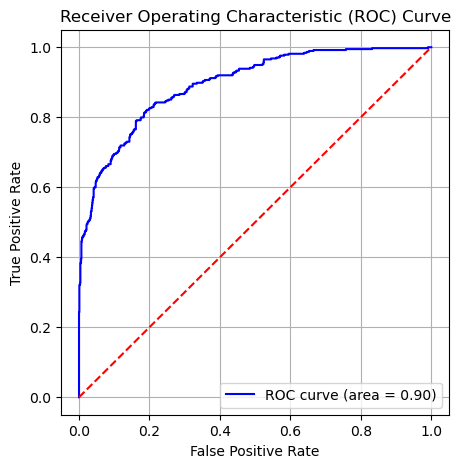

In [28]:
# Test the best model with 'test' dataset, and visualization: 

best_model = results['XGB']
y_test_pred = best_model.predict(X_test)          # Hard classes (0 or 1) for accuracy and F1 score
y_test_probs = best_model.predict_proba(X_test)[:, 1] # Probabilities for ROC-AUC

# 2. Calculate Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_probs)

# 3. Print Results
print("--- FINAL TEST SET METRICS (XGBoost) ---")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test ROC-AUC:  {test_roc_auc:.4f}")
print("-" * 40)

# INTEGRATED ROC CURVE SCRIPT
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_auc_test = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [30]:
#  Save and export the best model
os.makedirs("artifacts", exist_ok=True)
joblib.dump(best_model, "artifacts/model_pipeline.joblib")

['artifacts/model_pipeline.joblib']

## Conclusion
In this project, we analyzed customer data from the telecom operator Interconnect to build a predictive model for customer churn. The data underwent preprocessing, feature engineering, and exploratory data analysis (EDA) to prepare it for a supervised binary classification task.

For preprocessing, one-hot encoding (OHE) was applied to categorical features and StandardScaler was used for numerical features. Model selection involved cross-validation and hyperparameter tuning with GridSearchCV to ensure robust performance.

We trained and evaluated several classification models, including:

- Logistic Regression  
- Random Forest Classifier  
- LightGBM  
- XGBoost  
- CatBoost

Model performances were evaluated using the accuracy, ROC-AUC, and F1 score metrics. The results are summarized in the table below:


<div style="text-align:center">

| Model                   | Dataset      | Accuracy | ROC-AUC  | F1 Score |
|-------------------------|--------------|----------|----------|----------|
| LogisticRegression      |  validation  |  0.7580  |  0.8508  |  0.6368  |
| RandomForestClassifier  |  validation  |  0.8133  |  0.8751  |  0.6741  |
| LightGBMClassifier      |  validation  |  0.8297  |  0.9078  |  0.7066  |
| XGBClassifier           |  validation  |  0.8623  |  0.9118  |  0.7069  |
| CatboostClassifier      |  validation  |  0.8602  |  0.9106  |  0.7020  |
| XGBClassifier           |     test     |  0.8581  |  0.8953  |  0.7059  |

</div>

After fine-tuning the models' hyperparameters and evaluating them on the test dataset, XGBoost emerged as the best model, achieving a ROC-AUC of 0.8829.

Based on these results, we recommend using the XGBoost model with the tuned hyperparameters to predict customer churn for the company.